<a href="https://colab.research.google.com/github/ManavFCB/Crowd-Counting/blob/master/CC_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
from google.colab import drive
import pandas as pd
from scipy.ndimage import gaussian_filter
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


**Generate annotation maps**

In [ ]:
path = '/content/gdrive/MyDrive/nwpu/jsons'

In [ ]:
s = "annotation_map_5"
sigma = 5
for root, dirs, files in os.walk(path):
  print(root)
  for file in files:
    img_json = pd.read_json(os.path.join(root, file))
    img_name = file.split('.')[0]
    parent = root.split('/jsons')[0]
    if len(img_json) > 60 and img_json['human_num'].iloc[0] < 450: #larger numbers take time
      if not os.path.isfile(os.path.join(parent, s, img_name + ".jpg")):
        print(file)
        img = cv2.imread(os.path.join(parent, img_name+'.jpg'), cv2.IMREAD_GRAYSCALE)
        annotations = img_json['points']
        annotation_map = np.zeros(img.shape, dtype = 'int')
        for annotation in annotations:
          x = int(annotation[0])
          y = int(annotation[1])
          annotation_map[y, x] = 255
          map = gaussian_filter(annotation_map, sigma = sigma, order = 0)
        if not os.path.isdir(os.path.join(parent, s)):
          print("created:"+os.path.join(parent, s))
          os.mkdir(os.path.join(parent, s))
        cv2.imwrite(os.path.join(parent, s, img_name + ".jpg"), map)
      else:
        continue
    else:
      continue

/content/gdrive/MyDrive/nwpu/jsons
1216.json
1218.json
1217.json
1219.json
1220.json
1223.json
1221.json
1230.json
1229.json
1231.json
1232.json
1233.json
1234.json
1238.json
1240.json
1246.json
1247.json
1249.json
1248.json
1251.json
1253.json
1261.json
1262.json
1263.json
1266.json
1268.json
1270.json
1267.json
1271.json
1272.json
1274.json
1273.json
1277.json
1279.json
1280.json
1283.json
1287.json
1290.json
1291.json
1292.json
1293.json
1294.json
1295.json
1297.json
1299.json
1302.json
1304.json
1305.json
1303.json
1306.json
1307.json
1310.json
1311.json
1313.json
1312.json
1316.json
1317.json
1314.json
1318.json
1320.json
1321.json
1326.json
1325.json
1329.json
1331.json
1340.json
1342.json
1343.json
1345.json
1347.json
1346.json
1348.json
1349.json
1350.json
1352.json
1357.json
1355.json
1359.json
1356.json
1358.json
1362.json
1363.json
1367.json
1371.json
1372.json
1373.json
1375.json
1377.json
1378.json
1380.json
1381.json
1382.json
1383.json
1389.json
1390.json
1391.json


KeyboardInterrupt: ignored

In [ ]:
while True:
  pass

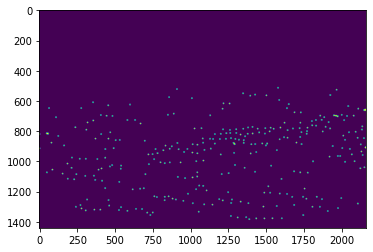

In [ ]:
s = cv2.imread('/content/gdrive/MyDrive/nwpu/annotation_map_5/1389.jpg', cv2.IMREAD_GRAYSCALE)
_, s = cv2.threshold(s, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(s)

In [ ]:
map = map.astype('uint8')

**Region Division**

**code to generate counts per region**

In [ ]:
# generates counts per region for every image. To be called in the function that divides the image
# div_coordinates should be a list of points at which the image is divided (inclusive of the start and end points); e.g [0, 360, 720, 1080, ...]
# this code assumes 9 regions per image.
def regionCountGenerate(img_json_df, div_coordinates):
  num_regions = (len(div_coordinates) - 1) ** 2
  counts = [0] * num_tuples
  for point in img_json_df['points']:
    num = check_range_x(point[0])
    if point[1] in range(div_coordinates[0], div_coordinates[1]):
      counts[0 + num] += 1
    elif point[1] in range(div_coordinates[1], div_coordinates[2]):
      counts[3 + num] += 1
    else:
      counts[6 + num] += 1

# perform boundary checks along x-axis
def check_range_x(point):
  if point in range(div_coordinates[0], div_coordinates[1]):
    return 0
  elif point in range(div_coordinates[1], div_coordinates[2]):
    return 1
  elif point in range(div_coordinates[2], div_coordinates[3]):
    return 2